# Deep learning

En este notebook se traen los pesos del modelo preentrenado y se usan como extracción de características, la única capa que se entrena es la de clasificación (la última)

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import imgaug.augmenters as iaa

import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from tqdm import tqdm

In [3]:
PROJECT_PATH = '.'
DATASETS_PATH = f'{PROJECT_PATH}/Datasets'
BASE_PATH = f'{PROJECT_PATH}/Recortes'
TARGET_SIZE = (256, 256)
CANTIDAD_DE_AUMENTOS = 0

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
def pad_with_average(image_path, target_size):
    # Leer la imagen con PIL
    image = Image.open(image_path)

    # Determinar las dimensiones para el redimensionamiento proporcional
    aspect_ratio = image.width / image.height
    if aspect_ratio > 1:
        # La imagen es más ancha que alta
        new_width = target_size[1]
        new_height = int(new_width / aspect_ratio)
    else:
        # La imagen es más alta que ancha
        new_height = target_size[0]
        new_width = int(new_height * aspect_ratio)

    # Redimensionar la imagen
    image = image.resize((new_width, new_height), Image.LANCZOS)

    # Convertir la imagen a un array para calcular el color promedio
    image_np = np.asarray(image)
    avg_color = tuple(map(int, np.mean(image_np, axis=(0, 1))))

    # Calcular cuánto padding es necesario
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    padding = (delta_w//2, delta_h//2)

    # Aplicar padding con el valor promedio
    padded_image = Image.new(image.mode, target_size,
                             avg_color)  # type: ignore
    padded_image.paste(image, padding)

    padded_image = np.array(padded_image)

    return padded_image

In [6]:
def generate_datasets(base_path):
    class_folders = os.listdir(base_path)

    data = []
    labels = []
    label_to_folder = {}  # Diccionario para almacenar la relación label-folder

    for label, folder_name in enumerate(class_folders):
        folder_path = os.path.join(base_path, folder_name)

        if os.path.isdir(folder_path):
            # Guardar en el diccionario la relación label-folder
            label_to_folder[label] = folder_name

            for image_name in os.listdir(folder_path):
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    data.append(os.path.join(folder_path, image_name))
                    labels.append(label)

    # Dividir los datos en conjuntos de entrenamiento y validación
    train_data, val_data, train_labels, val_labels = train_test_split(
        data, labels, test_size=0.2, stratify=labels, random_state=42)

    train_labels = np.array(train_labels)
    val_labels = np.array(val_labels)

    # Incluir el diccionario en la respuesta
    return train_data, val_data, train_labels, val_labels, label_to_folder

In [7]:
def augment_images(seq, image_rgb, num_augmented=CANTIDAD_DE_AUMENTOS):
    # Aplica la secuencia de aumentación a la imagen original
    augmented_images = seq(images=[image_rgb] * num_augmented)
    # Produce (yield) cada imagen aumentada una por una
    for augmented_image in augmented_images:
        yield augmented_image

In [8]:
def get_features(train_imgs, train_labels, output_path=None):
    # Listas para almacenar las imágenes y las etiquetas
    train_images = []
    augmented_labels = []

    total_images = len(train_imgs)
    count = 0
    # Define la secuencia de aumentación
    seq = iaa.Sequential([
        # recorta imágenes de cada lado por 0 a 16px (aleatoriamente elegido)
        iaa.Crop(px=(0, 16)),
        # refleja horizontalmente el 50% de las imágenes
        iaa.Fliplr(0.5),  # type: ignore
        # aplica desenfoque gaussiano con un sigma de 0 a 3.0
        iaa.GaussianBlur(sigma=(0, 3.0))
    ])
    size_0 = None
    # Procesar imágenes de entrenamiento
    for img_idx, img_path in enumerate(train_imgs):
        count += 1
        if count % 100 == 0:
            print(f"Processing image {count}/{total_images}")

        image = pad_with_average(img_path, TARGET_SIZE)

        train_images.append(image)
        # Agrega el label para la imagen original
        augmented_labels.append(train_labels[img_idx])

        for augmented_image in augment_images(seq, image):
            train_images.append(image)
            # Agrega el mismo label para cada imagen aumentada
            augmented_labels.append(train_labels[img_idx])

    # Convertir las listas a arrays de numpy
    train_images = np.stack(train_images, axis=0)
    augmented_labels = np.array(augmented_labels)

    if output_path is not None:
        np.save(output_path, train_images)

    return train_images, augmented_labels

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Argumentos:
            images (numpy.ndarray): Tu array de imágenes.
            labels (numpy.ndarray): Etiquetas correspondientes.
            transform (callable, opcional): Transformaciones opcionales a ser aplicadas
                en una muestra.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
def get_dataloader(images, labels, batch_size=32):
    # Normalmente, las transformaciones de torchvision esperan datos de imagen PIL,
    # pero aquí estamos trabajando con arrays de numpy, así que definimos nuestras propias transformaciones.
    def transform(image):
        # Convertir el array de numpy a un tensor de PyTorch.
        image = torch.from_numpy(image).float()

        # Reordenar las dimensiones a C x H x W
        image = image.permute(2, 0, 1)

        # Normalizar (esto es un ejemplo, deberías usar tus propios valores medios y std)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = (image / 255.0 - mean[:, None, None]) / std[:, None, None]

        return image

    # Crear un conjunto de datos personalizado y aplicar las transformaciones
    dataset = CustomImageDataset(
        images=images, labels=labels, transform=transform)

    # Crear un DataLoader utilizando el conjunto de datos personalizado
    # Esto manejará el batching, shuffling, y otras funcionalidades.
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [11]:
def train(train_loader, val_loader, num_features, model, num_epochs=10):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"There are {torch.cuda.device_count()} GPU(s) available.")
        print("Device name:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    model = model.to(device)

    train_loss_history = []
    train_precision_history = []
    val_loss_history = []
    val_precision_history = []

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        model.train()  # Entrenamiento del modelo
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Envuelves tu iterador con tqdm para crear una barra de progreso
        progress_bar = tqdm(enumerate(train_loader, 0),
                            total=len(train_loader))

        for i, data in progress_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # cero los gradientes de los parámetros
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calcular la precisión
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Actualizar la barra de progreso
            running_loss += loss.item()
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            progress_bar.set_postfix(loss=(running_loss / (i + 1)))

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train

        train_loss_history.append(epoch_loss)
        train_precision_history.append(epoch_acc)

        print(f"[{epoch + 1}] loss: {epoch_loss:.4f}, precision: {epoch_acc:.2f}%")

        # Ahora la parte de validación (evaluación) después de cada época
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:  # asumiendo que val_loader es tu DataLoader de validación
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcular la precisión
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val

        val_loss_history.append(epoch_val_loss)
        val_precision_history.append(epoch_val_acc)

        print(
            f"Validation loss: {epoch_val_loss:.4f}, Validation precision: {epoch_val_acc:.2f}%")

    print('Finished Training')

    return val_loss_history, val_precision_history, train_loss_history, train_precision_history

In [12]:
def plot_history(val_loss, val_precision, train_loss, train_precision):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Loss During Training and Validation")
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Precision During Training and Validation")
    plt.plot(train_precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.xlabel('Epoch Number')
    plt.ylabel('Precision (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def calculate_metrics(all_preds, all_labels):
    """
    Calcula las métricas por clase, y las métricas agregadas micro, macro y weighted.
    """
    # Inicializando diccionarios para almacenar métricas por clase
    metrics_per_class = {cls: {'accuracy': 0.0, 'precision': 0.0,
                               'recall': 0.0, 'f1': 0.0} for cls in all_preds.keys()}

    # Listas para almacenar todos los valores (para métricas micro y macro)
    all_true_labels = []
    all_predictions = []

    # Unir todas las métricas en una sola lista
    for cls in all_preds.keys():
        all_true_labels.extend(all_labels[cls])
        all_predictions.extend(all_preds[cls])

    all_true_labels = np.array(all_true_labels)
    all_predictions = np.array(all_predictions)

    # Calcular métricas por clase
    for cls in all_preds.keys():
        # Calcular tp, fp, fn, tn
        tp = np.sum((all_predictions == cls) & (all_true_labels == cls))
        fp = np.sum((all_predictions == cls) & (all_true_labels != cls))
        fn = np.sum((all_predictions != cls) & (all_true_labels == cls))
        tn = np.sum((all_predictions != cls) & (all_true_labels != cls))

        # Calcular métricas
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (
            precision + recall) > 0 else 0.0

        # Agregar las métricas al diccionario
        metrics_per_class[cls]['accuracy'] = accuracy
        metrics_per_class[cls]['precision'] = precision
        metrics_per_class[cls]['recall'] = recall
        metrics_per_class[cls]['f1'] = f1

    # Calcular métricas micro
    micro_precision = precision_score(
        all_true_labels, all_predictions, average='micro')
    micro_recall = recall_score(
        all_true_labels, all_predictions, average='micro')
    micro_f1 = f1_score(all_true_labels, all_predictions, average='micro')

    # Calcular métricas macro
    macro_precision = precision_score(
        all_true_labels, all_predictions, average='macro')
    macro_recall = recall_score(
        all_true_labels, all_predictions, average='macro')
    macro_f1 = f1_score(all_true_labels, all_predictions, average='macro')

    # Calcular métricas weighted
    weighted_precision = precision_score(
        all_true_labels, all_predictions, average='weighted')
    weighted_recall = recall_score(
        all_true_labels, all_predictions, average='weighted')
    weighted_f1 = f1_score(
        all_true_labels, all_predictions, average='weighted')

    # Agregando las métricas micro, macro y weighted a un diccionario
    aggregated_metrics = {
        'micro': {'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1},
        'macro': {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1},
        'weighted': {'precision': weighted_precision, 'recall': weighted_recall, 'f1': weighted_f1}
    }

    return metrics_per_class, aggregated_metrics

In [14]:
train_paths, val_paths, train_labels, val_labels, label_to_dirname = generate_datasets(
    BASE_PATH)

if not os.path.exists(DATASETS_PATH):
    os.makedirs(DATASETS_PATH)
"""
if os.path.exists(f'{DATASETS_PATH}/x_train.npy')
    train_images = np.load(f'{DATASETS_PATH}/x_train.npy')
else:
    train_images, train_labels = get_features(train_paths, train_labels)

if os.path.exists(f'{DATASETS_PATH}/x_test.npy')
    val_images = np.load(f'{DATASETS_PATH}/x_test.npy')
else:
    val_images, val_labels = get_features(val_paths, val_labels)
"""

train_images, train_labels = get_features(train_paths, train_labels)
val_images, val_labels = get_features(val_paths, val_labels)

Processing image 100/17640
Processing image 200/17640
Processing image 300/17640
Processing image 400/17640
Processing image 500/17640
Processing image 600/17640
Processing image 700/17640
Processing image 800/17640
Processing image 900/17640
Processing image 1000/17640
Processing image 1100/17640
Processing image 1200/17640
Processing image 1300/17640
Processing image 1400/17640
Processing image 1500/17640
Processing image 1600/17640
Processing image 1700/17640
Processing image 1800/17640
Processing image 1900/17640
Processing image 2000/17640
Processing image 2100/17640
Processing image 2200/17640
Processing image 2300/17640
Processing image 2400/17640
Processing image 2500/17640
Processing image 2600/17640
Processing image 2700/17640
Processing image 2800/17640
Processing image 2900/17640
Processing image 3000/17640
Processing image 3100/17640
Processing image 3200/17640
Processing image 3300/17640
Processing image 3400/17640
Processing image 3500/17640
Processing image 3600/17640
P

In [15]:
num_features = train_images.shape[1]
unique_labels = np.unique(train_labels)
num_classes = len(unique_labels)

In [16]:
train_images.shape

(17640, 256, 256, 3)

In [17]:
train_loader = get_dataloader(train_images, train_labels)
val_loader = get_dataloader(val_images, val_labels)

In [18]:
label_to_dirname = {
    key: f"{key}-{value.split('-')[-1].replace('_', ' ')}" for key, value in label_to_dirname.items()}

In [19]:
final_results = {}

## ResNet101

In [20]:
# Cargar el modelo preentrenado, en este caso ResNet101
model = models.resnet101(weights='IMAGENET1K_V1')

# Cambiar la última capa para 120 clases de salida
model.fc = nn.Linear(model.fc.in_features, 120)

# Desactivar gradiente para todas las capas, asegurando la extracción de características
for param in model.parameters():
    param.requires_grad = False

# Activar cálculo de gradientes solo para la última capa si se va a entrenar con nuevos datos
for param in model.fc.parameters():
    param.requires_grad = True

In [21]:
val_loss_history, val_precision_history, train_loss_history, \
    train_precision_history = train(
        train_loader, val_loader, num_features, model)

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 4070 Ti


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.37it/s, loss=3.17]


[1] loss: 3.1696, precision: 49.81%
Validation loss: 1.7585, Validation precision: 78.46%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:37<00:00, 14.62it/s, loss=1.45]


[2] loss: 1.4493, precision: 80.60%
Validation loss: 1.0042, Validation precision: 83.90%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:37<00:00, 14.54it/s, loss=0.974]


[3] loss: 0.9743, precision: 84.33%
Validation loss: 0.7733, Validation precision: 84.79%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.46it/s, loss=0.781]


[4] loss: 0.7809, precision: 85.63%
Validation loss: 0.6600, Validation precision: 85.56%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.50it/s, loss=0.687]


[5] loss: 0.6871, precision: 86.57%
Validation loss: 0.5869, Validation precision: 86.56%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.49it/s, loss=0.623]


[6] loss: 0.6226, precision: 87.24%
Validation loss: 0.5595, Validation precision: 86.22%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.47it/s, loss=0.575]


[7] loss: 0.5751, precision: 87.87%
Validation loss: 0.5210, Validation precision: 86.37%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.48it/s, loss=0.542]


[8] loss: 0.5421, precision: 87.95%
Validation loss: 0.4994, Validation precision: 87.03%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.44it/s, loss=0.52]


[9] loss: 0.5196, precision: 88.25%
Validation loss: 0.4898, Validation precision: 87.08%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:38<00:00, 14.48it/s, loss=0.502]


[10] loss: 0.5021, precision: 88.23%
Validation loss: 0.4746, Validation precision: 87.26%
Finished Training


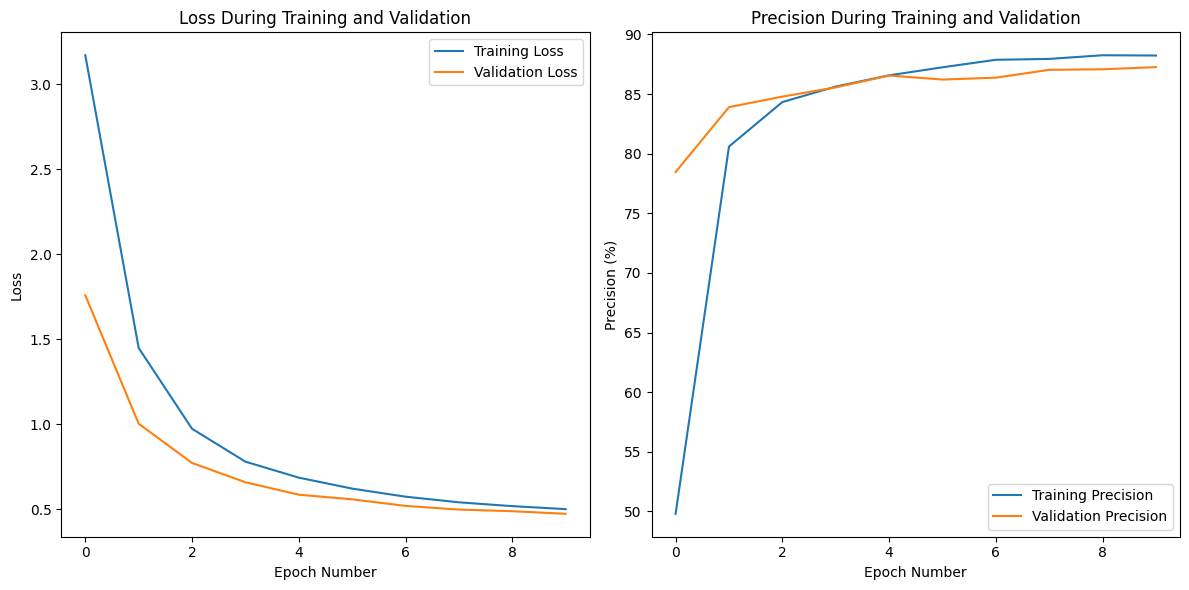

In [22]:
plot_history(val_loss_history, val_precision_history,
             train_loss_history, train_precision_history)

In [23]:
final_mean_precision = np.mean(val_precision_history[-5:])
print(f"Final mean precision in validation set: {final_mean_precision:.2f}%")

Final mean precision in validation set: 86.79%


## Convert to ONNX

In [24]:
model.eval()

# Inicializar un diccionario para almacenar las predicciones y etiquetas verdaderas por raza
all_preds = {i: [] for i in range(num_classes)}
all_labels = {i: [] for i in range(num_classes)}

device = model.parameters().__next__().device

with torch.no_grad():
    progress_bar = tqdm(val_loader)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.cpu()
        predicted = predicted.cpu()
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            all_preds[label].append(pred)
            all_labels[label].append(label)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:08<00:00, 15.49it/s]


In [25]:
metrics_per_class, aggregated_metrics = calculate_metrics(
    all_preds, all_labels)

In [26]:
data = {
    'Raza': [label_to_dirname[label] for label in unique_labels],
    'Precision': [metrics_per_class[label]['precision'] for label in unique_labels],
    'Recall': [metrics_per_class[label]['recall'] for label in unique_labels],
    'F1': [metrics_per_class[label]['f1'] for label in unique_labels],
    'Accuracy': [metrics_per_class[label]['accuracy'] for label in unique_labels]
}

df = pd.DataFrame(data)
df.sort_values(by='F1')

,Raza,Precision,Recall,F1,Accuracy
78,78-Eskimo dog,0.550,0.344,0.423,0.993
103,103-collie,0.737,0.412,0.528,0.994
27,27-miniature poodle,0.923,0.375,0.533,0.995
99,99-Siberian husky,0.553,0.619,0.584,0.992
54,54-Walker hound,0.789,0.469,0.588,0.995
94,94-American Staffordshire terrier,0.857,0.529,0.655,0.996
2,2-Staffordshire bullterrier,0.562,0.818,0.667,0.994
76,76-Lhasa,0.714,0.658,0.685,0.995
1,1-Border collie,0.604,0.906,0.725,0.995
114,114-toy poodle,0.643,0.844,0.730,0.995


In [27]:
aggregated_metrics

{'micro': {'precision': 0.8725912491498526,
  'recall': 0.8725912491498526,
  'f1': 0.8725912491498525},
 'macro': {'precision': 0.8772062955879573,
  'recall': 0.869296056084163,
  'f1': 0.8683637806739749},
 'weighted': {'precision': 0.8773715345749029,
  'recall': 0.8725912491498526,
  'f1': 0.8703705048567282}}

#### Accuracy

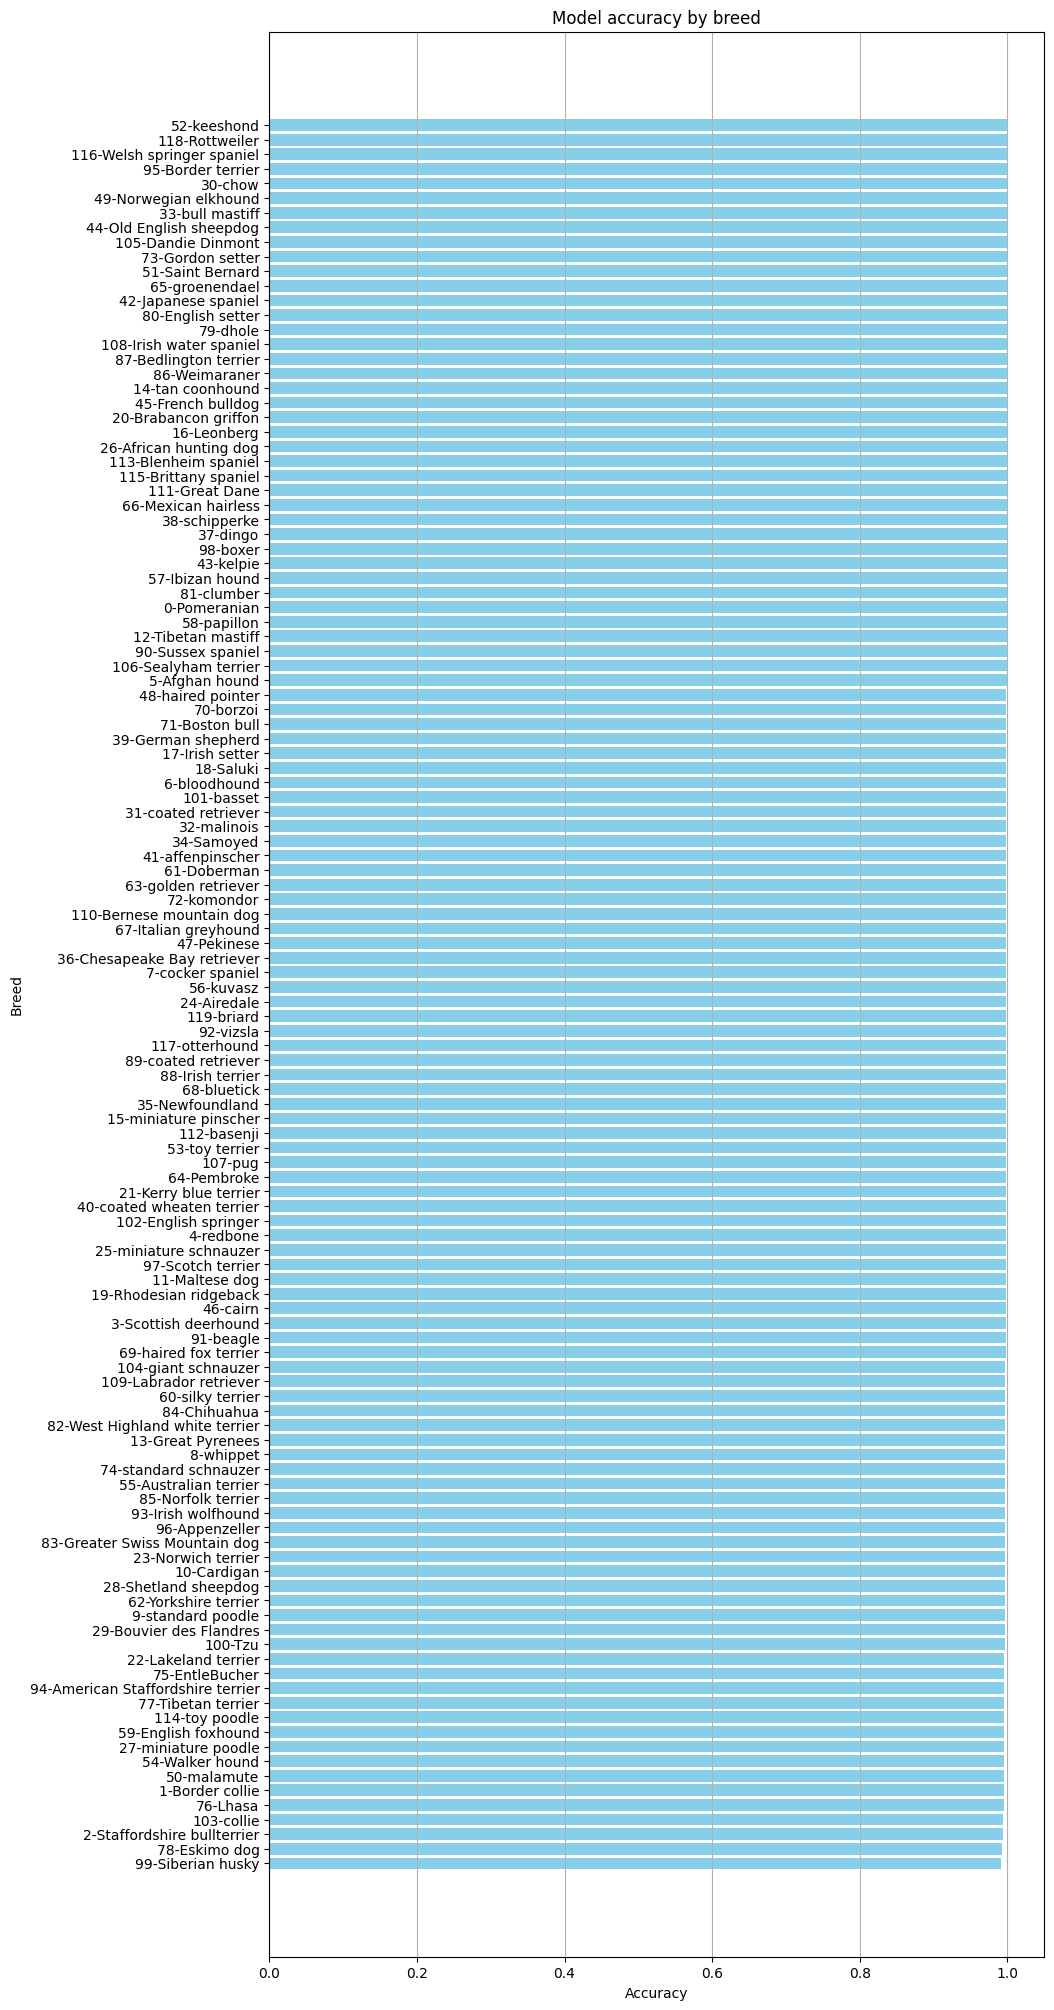

In [28]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 25))
df = df.sort_values(by='Accuracy')
plt.barh(df['Raza'], df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Breed')
plt.title('Model accuracy by breed')
plt.grid(axis='x')
plt.show()

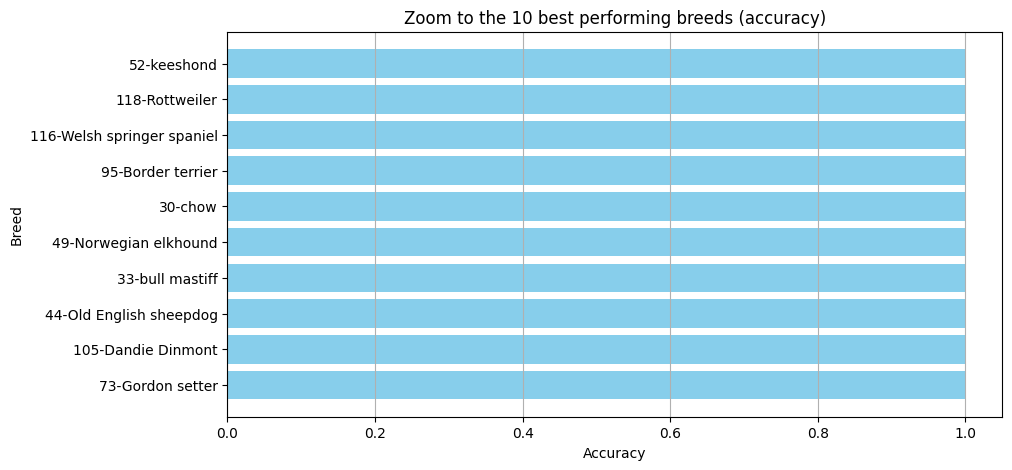

In [29]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(df['Raza'].tail(10), df['Accuracy'].tail(10), color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Breed')
plt.title('Zoom to the 10 best performing breeds (accuracy)')
plt.grid(axis='x')
plt.show()

#### Precision

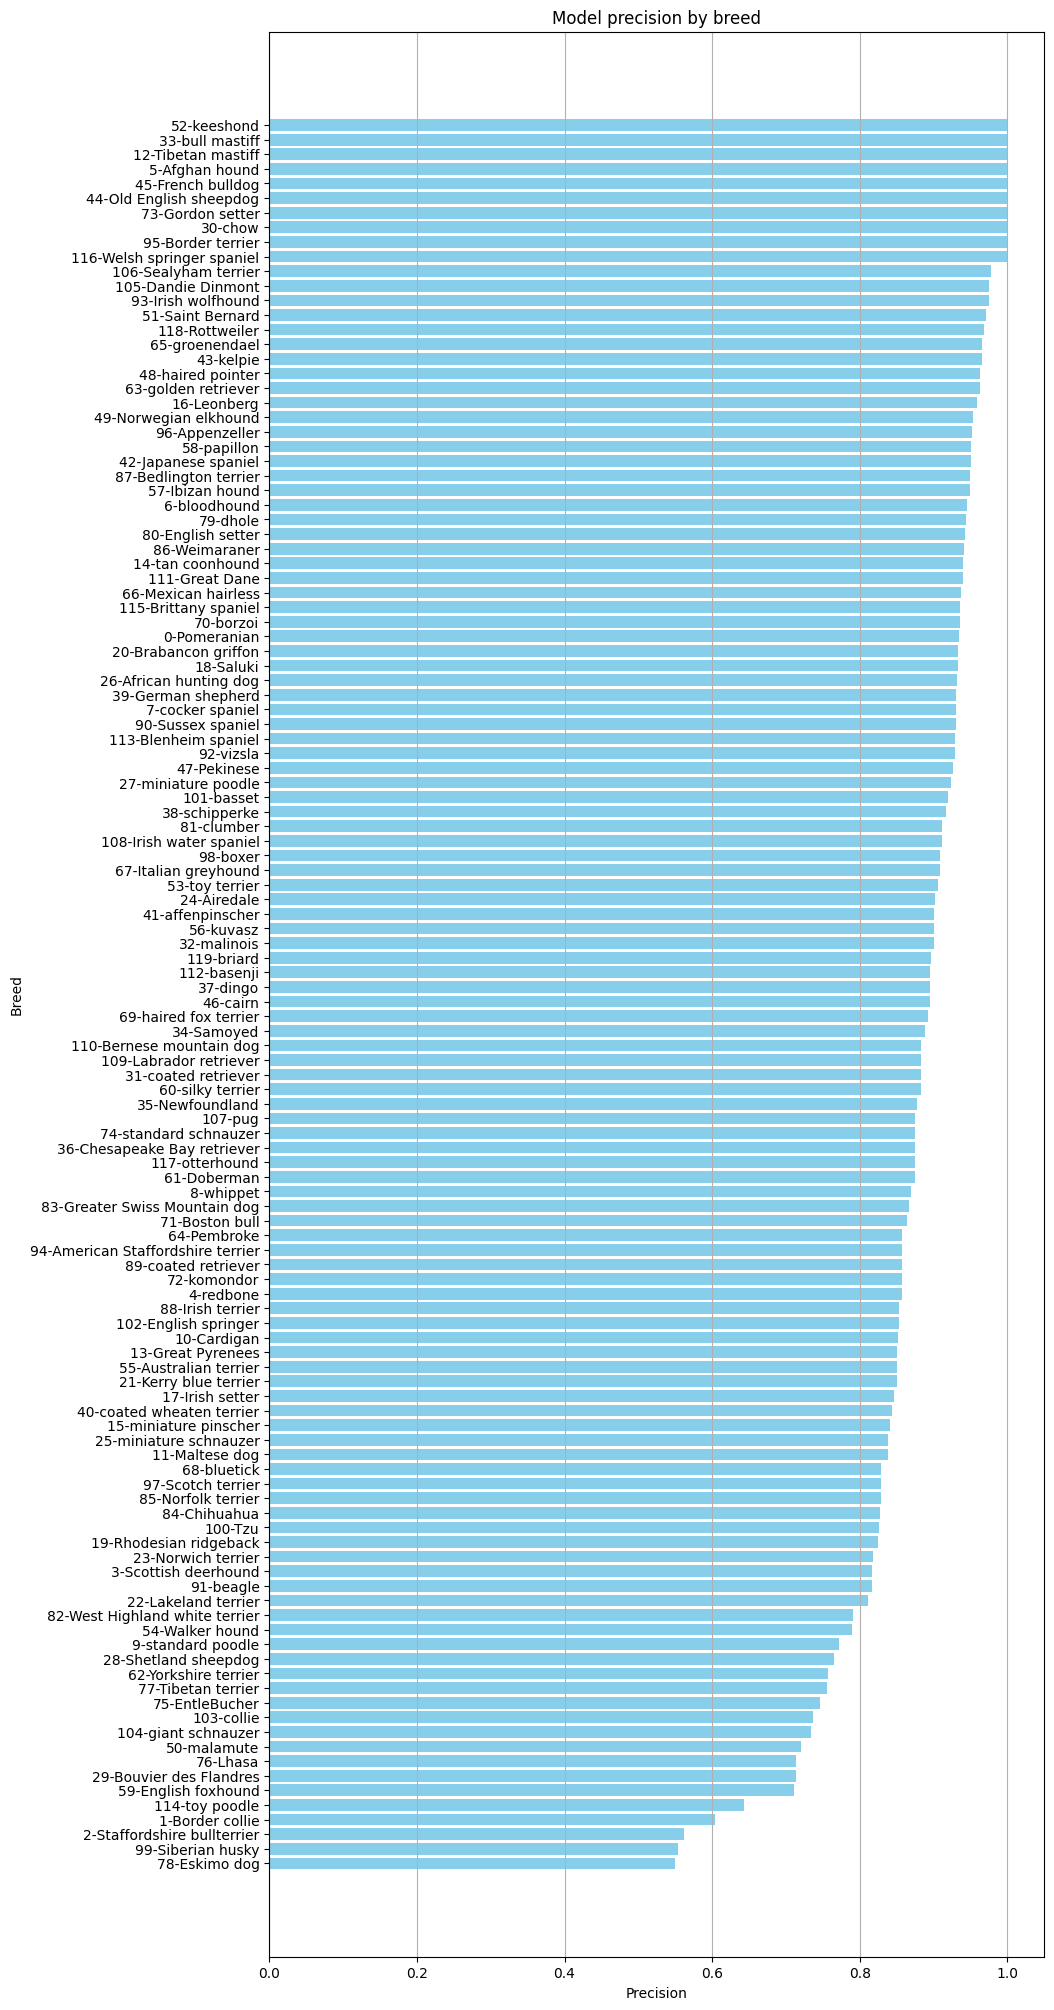

In [30]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 25))
df = df.sort_values(by='Precision')
plt.barh(df['Raza'], df['Precision'], color='skyblue')
plt.xlabel('Precision')
plt.ylabel('Breed')
plt.title('Model precision by breed')
plt.grid(axis='x')
plt.show()

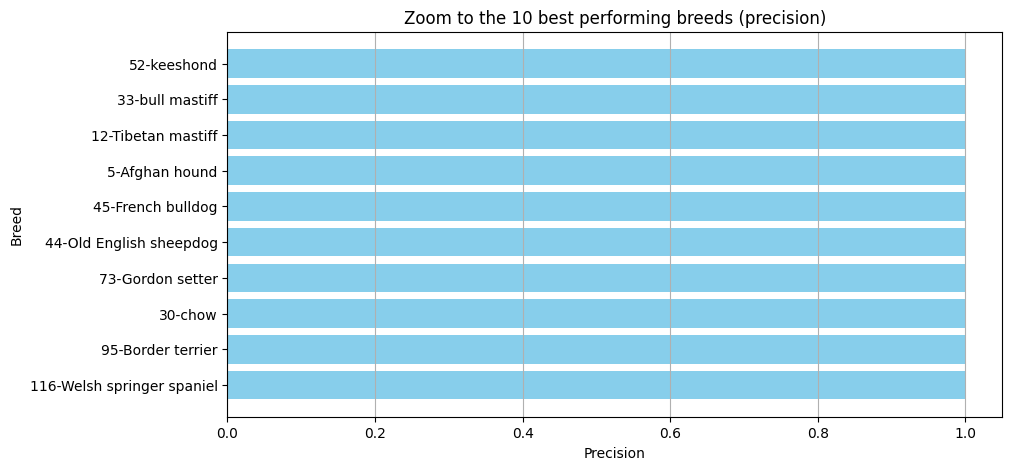

In [31]:
plt.figure(figsize=(10, 5))
plt.barh(df['Raza'].tail(10), df['Precision'].tail(10), color='skyblue')
plt.xlabel('Precision')
plt.ylabel('Breed')
plt.title('Zoom to the 10 best performing breeds (precision)')
plt.grid(axis='x')
plt.show()

#### Recall

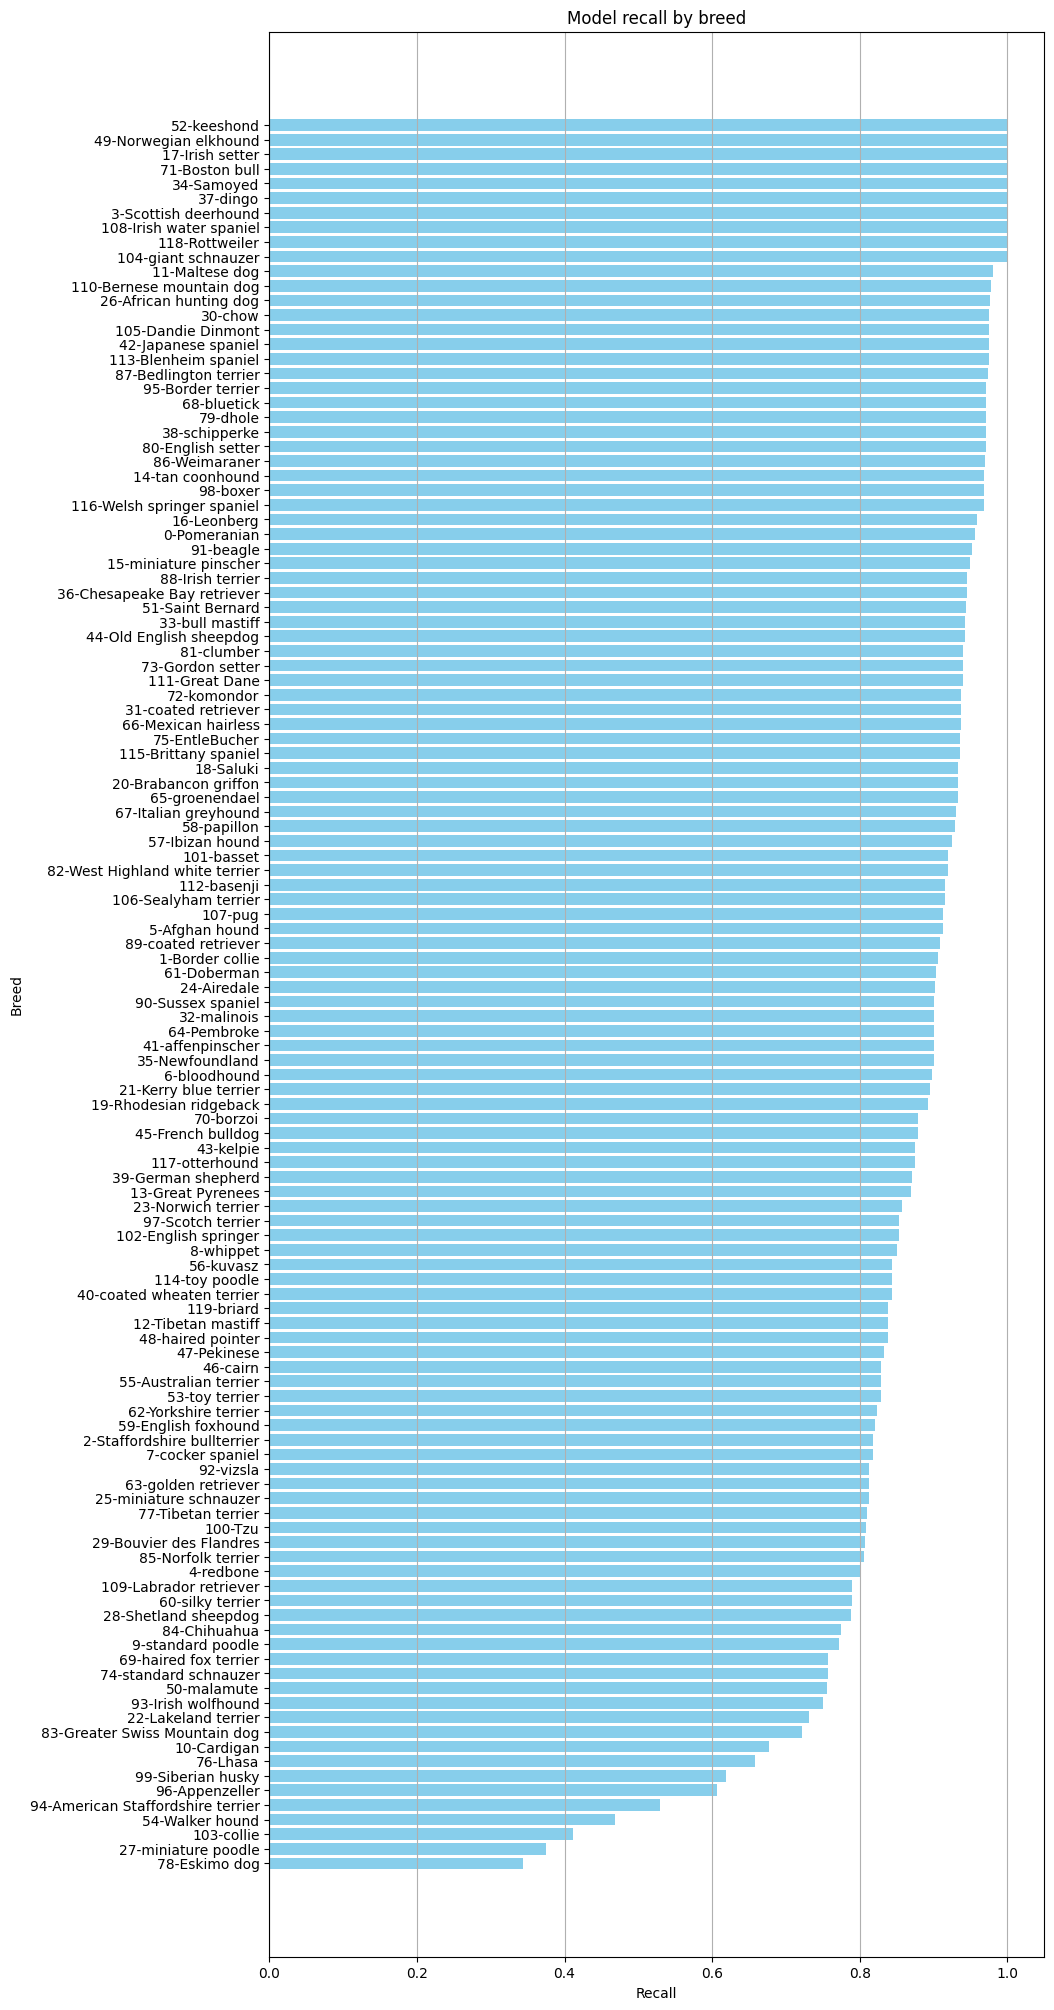

In [32]:
plt.figure(figsize=(10, 25))
df = df.sort_values(by='Recall')
plt.barh(df['Raza'], df['Recall'], color='skyblue')
plt.xlabel('Recall')
plt.ylabel('Breed')
plt.title('Model recall by breed')
plt.grid(axis='x')
plt.show()

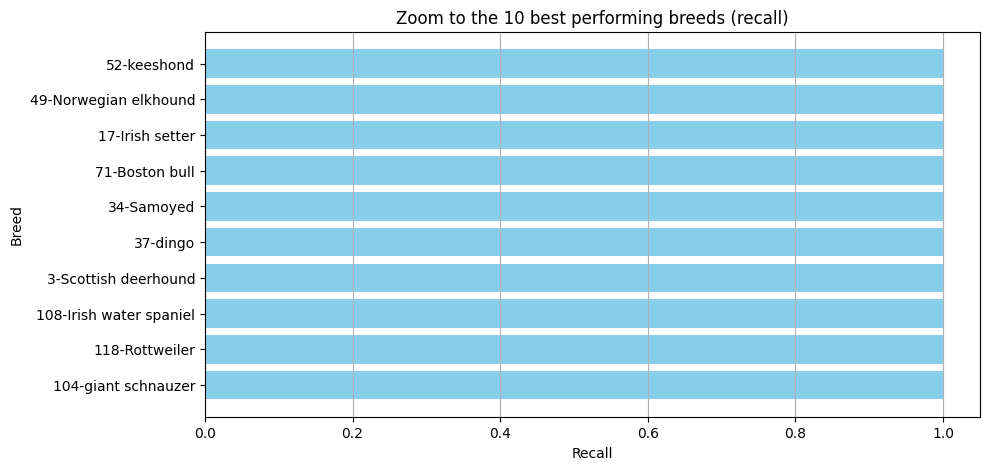

In [33]:
plt.figure(figsize=(10, 5))
plt.barh(df['Raza'].tail(10), df['Recall'].tail(10), color='skyblue')
plt.xlabel('Recall')
plt.ylabel('Breed')
plt.title('Zoom to the 10 best performing breeds (recall)')
plt.grid(axis='x')
plt.show()

#### F1-score

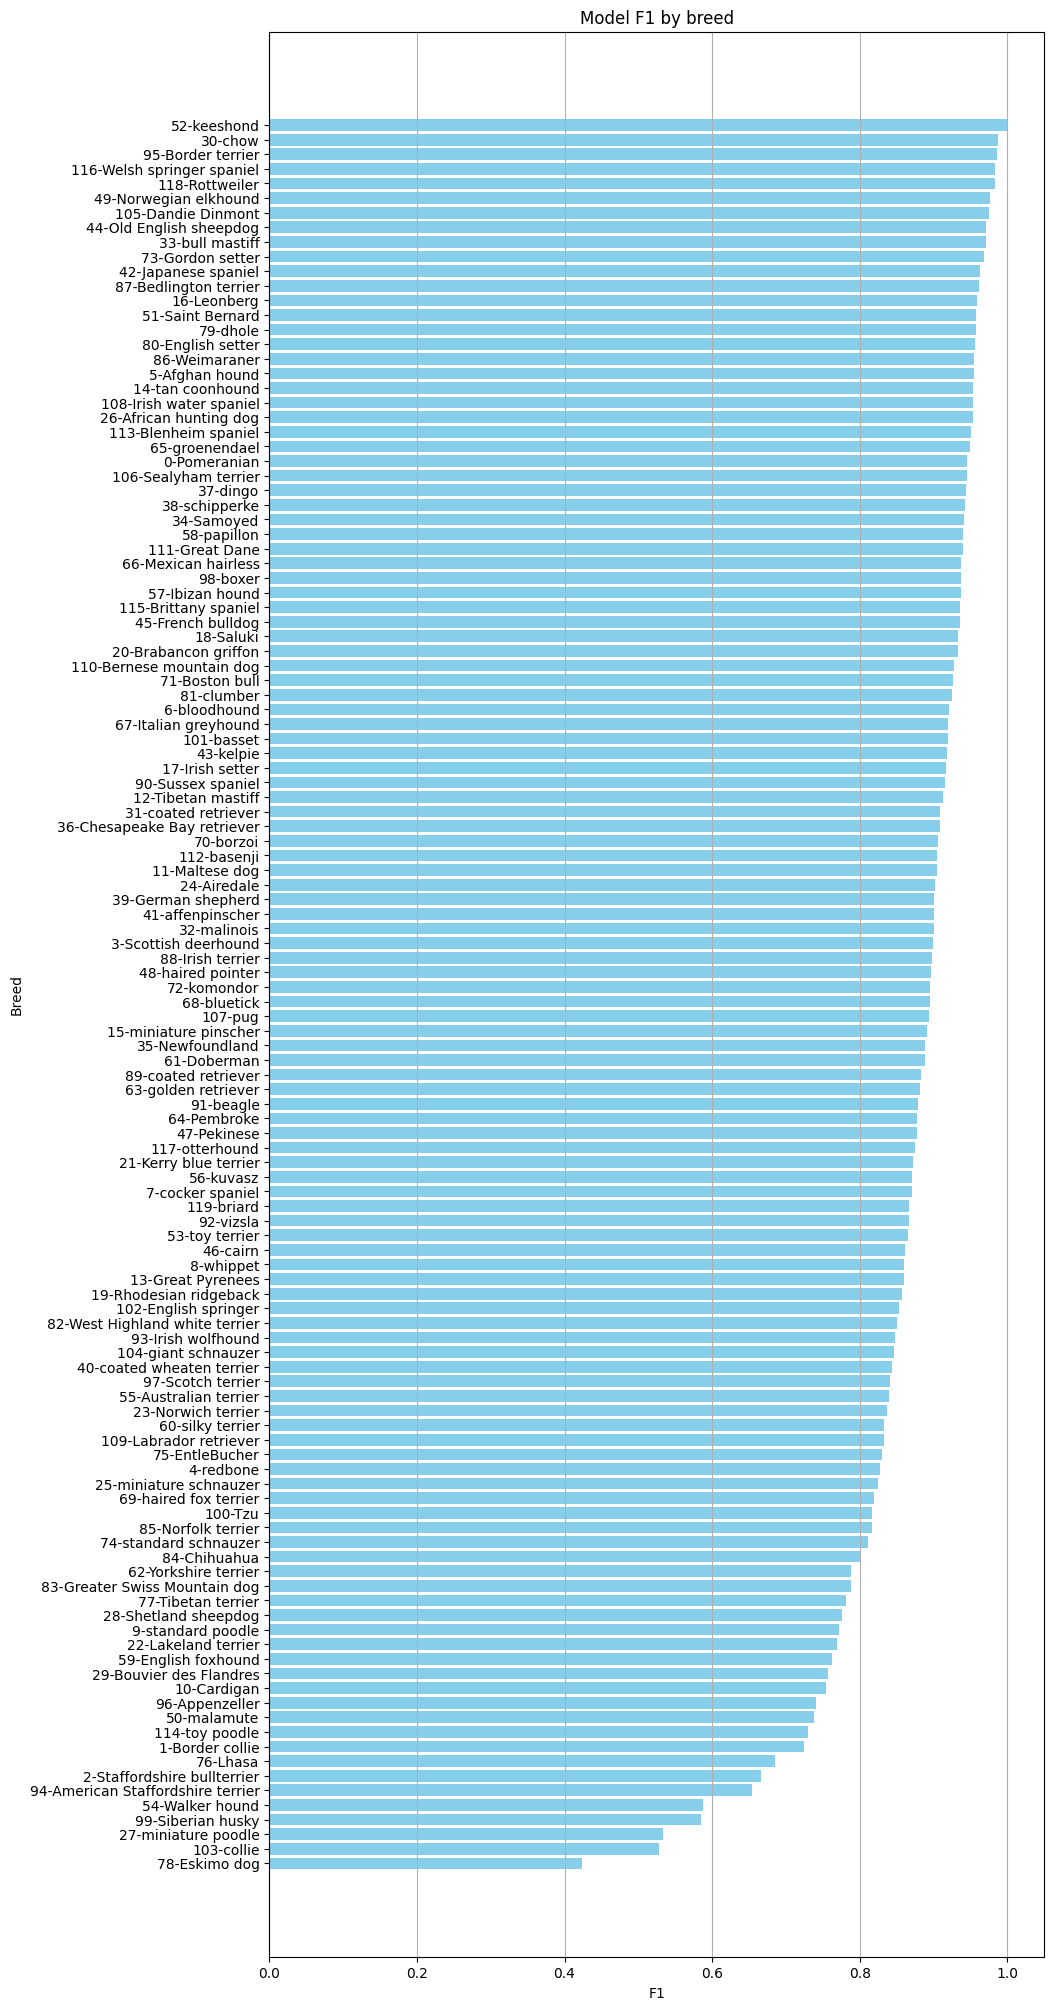

In [34]:
plt.figure(figsize=(10, 25))
df = df.sort_values(by='F1')
plt.barh(df['Raza'], df['F1'], color='skyblue')
plt.xlabel('F1')
plt.ylabel('Breed')
plt.title('Model F1 by breed')
plt.grid(axis='x')
plt.show()

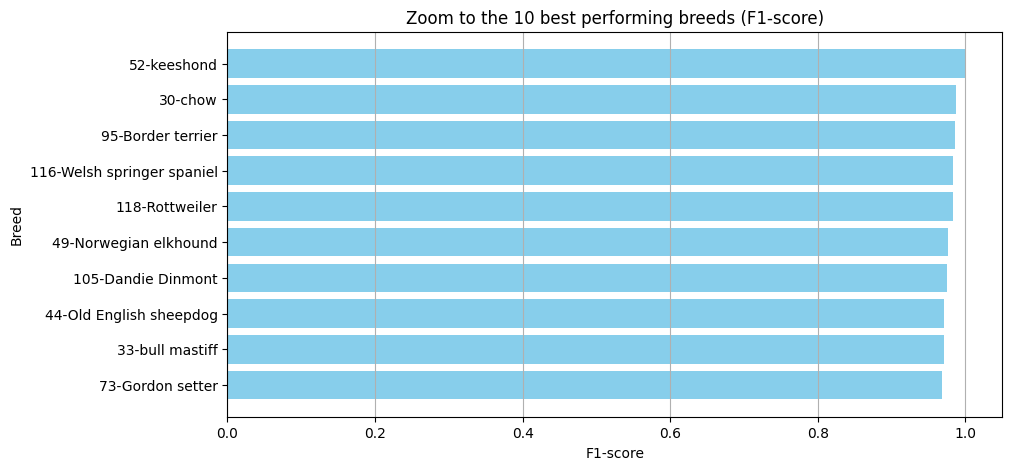

In [35]:
plt.figure(figsize=(10, 5))
plt.barh(df['Raza'].tail(10), df['F1'].tail(10), color='skyblue')
plt.xlabel('F1-score')
plt.ylabel('Breed')
plt.title('Zoom to the 10 best performing breeds (F1-score)')
plt.grid(axis='x')
plt.show()

In [36]:
# Agrega un softmax al final del modelo
model = nn.Sequential(model, nn.Softmax(dim=1))

model.eval()

# Prepara la entrada de ejemplo
example_input = torch.rand(1, 3, TARGET_SIZE[0], TARGET_SIZE[1]).to(device)

# Exporta el modelo
output_onnx = 'backend/model/resnet101_dogs.onnx'
torch.onnx.export(model, example_input, output_onnx, export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

In [37]:
# Guarde el mapeo de clases a nombres de razas
import json

with open('backend/model/label_to_dirname.json', 'w') as fp:
    json.dump(label_to_dirname, fp)